## Import Module

In [8]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Environment Class

In [9]:
class Environment:
    
    # constructor
    def __init__(self, company1, company2, price_col, training_dataset_ratio=0.8, nrm=1, one_episode_num_step=30):
        
        self.company1 = company1
        self.stock_price1 = None
        self.stock_price1_train = None
        self.stock_price1_test = None
        
        self.company2 = company2
        self.stock_price2 = None
        self.stock_price2_train = None
        self.stock_price2_test = None
        
        self.price_col = price_col
        self.stock_price_length = None
        
        self.training_dataset_ratio = training_dataset_ratio
        self.nrm = nrm
        
        self.stock_price_final = []
        self.local_current_step = None
        self.global_current_step = None
        self.purpose = None
        self.old_prupoese = None
        self.one_episode_num_step = one_episode_num_step
        
        # read two company's stock price
        self.load_data()
        
        # extract close price from two stock price and convert to numpy array
        self.extract_close_price()
        
        # split two stock close price into training set and testing set
        self.split_dataset()
        
        # record system's info
        self.system_holding_stock1_unit = None
        self.system_holding_stock1_avg_price = None
        self.system_holding_stock1_wait2sell = False
        self.system_holding_stock2_unit = None
        self.system_holding_stock2_avg_price = None
        self.system_holding_stock2_wait2sell = False
        
    
    # read two company's stock price
    def load_data(self):
        
        try:
            self.stock_price1 = pd.read_csv(self.company1 + ".csv")
        except:
            raise Exception("Cannot load {}".format(self.company1 + ".csv"))
            
        try:
            self.stock_price2 = pd.read_csv(self.company2 + ".csv")
        except:
            raise Exception("Cannot load {}".format(self.company2 + ".csv"))
            
    
    # extract close price from two stock price and convert to numpy array
    def extract_close_price(self):
        
        try:
            self.stock_price1 = self.stock_price1[self.price_col]
            self.stock_price2 = self.stock_price2[self.price_col]
        except:
            raise Exception("Cannot extract stock price column: {}.".format(self.price_col))
            
        
        self.stock_price1 = self.stock_price1.values
        self.stock_price2 = self.stock_price2.values
        self.stock_price_length = len(self.stock_price1)
        
        
    # split two stock close price into training set and testing set
    def split_dataset(self):
        
        index = round(self.stock_price_length * self.training_dataset_ratio)
        
        self.stock_price1_train = self.stock_price1[:index]
        self.stock_price1_test = self.stock_price1[index:]
        
        self.stock_price2_train = self.stock_price2[:index]
        self.stock_price2_test = self.stock_price2[index:]
        
        print("===============Environment Info===============")
        print("Stock1: {}".format(self.company1))
        print("Stock2: {}".format(self.company2))
        print("Price Column: {}".format(self.price_col))
        print("Ngative Return Multiplier: {}".format(self.nrm))
        print("Number of Days in One Episode: {}".format(self.one_episode_num_step))
        print("Total number of day for training: {}".format(str(len(self.stock_price1_train))))
        print("Total number of day for testing: {}".format(str(len(self.stock_price1_test))))
        print("==============================================")
        
    
    # reset environment: must specify purpose for training or tetsing
    def reset(self, purpose):
        
        self.purpose = purpose
        
        if self.purpose != self.old_prupoese:
            self.stock_price_final = []
            self.prepare_final_data()
            self.old_prupoese = self.purpose
            self.global_current_step = -1
        
        self.global_current_step += 1
        self.local_current_step = 0
        
        self.system_holding_stock1_unit = 0
        self.system_holding_stock1_avg_price = 0
        self.system_holding_stock1_wait2sell = False
        self.system_holding_stock2_unit = 0
        self.system_holding_stock2_avg_price = 0
        self.system_holding_stock2_wait2sell = False
        
        if self.global_current_step == len(self.stock_price_final)-self.one_episode_num_step+1:
            self.global_current_step = 0
            
        '''
        format of state environment should return:
        state: [current stock1 price,
                number of units of stock1 which system holding,
                current stock2 price,
                number of units of stock2 which system holding,
                current spread,
                spread return,
                spread mean during past 15 days,
                current spread / spread mean during past 15 days,
                spread mean during past 10 days,
                current spread / spread mean during past 10 days
                spread mean during past 7 days
                current spread / spread mean during past 7 days
                spread mean during past 5 days
                current spread / spread mean during past 5 days]
        '''
        if self.purpose == "train":
            stock_price1 = self.stock_price1_train[self.global_current_step]
            stock_price2 = self.stock_price2_train[self.global_current_step]
        else:
            stock_price1 = self.stock_price1_test[self.global_current_step]
            stock_price2 = self.stock_price2_test[self.global_current_step]
        
        
        additional_state = np.array([stock_price1, int(self.system_holding_stock1_wait2sell), self.system_holding_stock1_unit, stock_price2, int(self.system_holding_stock2_wait2sell), self.system_holding_stock2_unit])
        original_state = self.stock_price_final[self.global_current_step]
        
        return np.insert(original_state, 0, additional_state)
            
            
    # prepare train data
    def prepare_final_data(self):
        
        # spread of two stock
        if self.purpose == "train":
            spread = self.stock_price1_train - self.stock_price2_train
        else:
            spread = self.stock_price1_test - self.stock_price2_test
        
        
        for idx, value in enumerate(spread):
            
            one_step = np.empty(shape=(10))
            one_step_idx = 0
            
            # current spread
            current_spread = value
            one_step[one_step_idx] = current_spread
            one_step_idx += 1
            
            # daily return of spread
            yesterday_spread = spread[idx-1] if idx-1 >= 0 else value
            daily_return_spread = current_spread - yesterday_spread
            one_step[one_step_idx] = daily_return_spread
            one_step_idx += 1
            
            # spread mean during past 15 days
            if idx != 0:
                temp_idx = 0 if (idx-15<0) else (idx-15)
                spread_mean_15_days = np.mean(spread[temp_idx:idx])
            else:
                spread_mean_15_days = value
            
            one_step[one_step_idx] = spread_mean_15_days
            one_step_idx += 1
            
            # curren spread / spread mean during past 15 days
            one_step[one_step_idx] = current_spread / spread_mean_15_days
            one_step_idx += 1
            
            # spread mean during past 10 days
            if idx != 0:
                temp_idx = 0 if (idx-10<0) else (idx-10)
                spread_mean_10_days = np.mean(spread[temp_idx:idx])
            else:
                spread_mean_10_days = value
            one_step[one_step_idx] = spread_mean_10_days
            one_step_idx += 1
            
            # curren spread / spread mean during past 10 days
            one_step[one_step_idx] = current_spread / spread_mean_10_days
            one_step_idx += 1
            
            # spread mean during past 7 days
            if idx != 0:
                temp_idx = 0 if (idx-7<0) else (idx-7)
                spread_mean_7_days = np.mean(spread[temp_idx:idx])
            else:
                spread_mean_7_days = value
            one_step[one_step_idx] = spread_mean_7_days
            one_step_idx += 1
            
            # curren spread / spread mean during past 7 days
            one_step[one_step_idx] = current_spread / spread_mean_7_days
            one_step_idx += 1
            
            # spread mean during past 5 days
            if idx != 0:
                temp_idx = 0 if (idx-5<0) else (idx-5)
                spread_mean_5_days = np.mean(spread[temp_idx:idx])
            else:
                spread_mean_5_days = value
            one_step[one_step_idx] = spread_mean_5_days
            one_step_idx += 1
            
            # curren spread / spread mean during past 5 days
            one_step[one_step_idx] = current_spread / spread_mean_5_days
            one_step_idx += 1
            
            self.stock_price_final.append(one_step)
            
    # get next new state
    def get_new_state(self, step_idx):
        
        '''
        format of state environment should return:
        state: [current stock1 price,
                number of units of stock1 which system holding,
                current stock2 price,
                number of units of stock2 which system holding,
                current spread,
                spread return,
                spread mean during past 15 days,
                current spread / spread mean during past 15 days,
                spread mean during past 10 days,
                current spread / spread mean during past 10 days
                spread mean during past 7 days
                current spread / spread mean during past 7 days
                spread mean during past 5 days
                current spread / spread mean during past 5 days]
        '''
        
        if self.purpose == "train":
            stock_price1 = self.stock_price1_train[step_idx]
            stock_price2 = self.stock_price2_train[step_idx]
        else:
            stock_price1 = self.stock_price1_test[step_idx]
            stock_price2 = self.stock_price2_test[step_idx]
        
        original_new_state = self.stock_price_final[step_idx]
        additional_new_state = np.array([stock_price1, int(self.system_holding_stock1_wait2sell), self.system_holding_stock1_unit, stock_price2, int(self.system_holding_stock2_wait2sell), self.system_holding_stock2_unit])
        return np.insert(original_new_state, 0, additional_new_state)
    
    
    # calculate reward given system's action
    def calculate_reward(self, step_idx, action):
        
        # print("Calculate Reward")
        
        '''
        format of action environment should receive:
        action: [current pattern,
                 quantity for two stocks]
        
        current pattern: 
        type: integer
        0 => buy stock1 and sell stock2
        1 => sell stock1 and buy stock2
        2 => no operation
        
        quantity for two stocks: 
        type: list
        [0~10, 0~10] (11*11 combination) 
        '''
        
        if self.purpose == "train":
            stock_price1 = self.stock_price1_train[step_idx]
            stock_price2 = self.stock_price2_train[step_idx]
        else:
            stock_price1 = self.stock_price1_test[step_idx]
            stock_price2 = self.stock_price2_test[step_idx]
            
            
        pattern = action[0]
        quantity = action[1]
        stock1_quantity = quantity[0]
        stock2_quantity = quantity[1]
        
        # buy stock1 and sell stock2
        if pattern == 0:
            
            # print("Pattern = 0")
            
            # process stock1
            
            # already buy some units of stock1
            if self.system_holding_stock1_wait2sell is True:
                self.system_holding_stock1_wait2sell = True
                
                if (self.system_holding_stock1_unit + stock1_quantity) == 0:
                    self.system_holding_stock1_avg_price = 0
                else:
                    self.system_holding_stock1_avg_price = ((self.system_holding_stock1_unit * self.system_holding_stock1_avg_price)+(stock1_quantity * stock_price1))/(self.system_holding_stock1_unit + stock1_quantity)
                
                
                self.system_holding_stock1_unit += stock1_quantity
                reward = 0
            
            # already sell some units of stock1
            else:
                q = min(self.system_holding_stock1_unit, stock1_quantity)
                reward = (self.system_holding_stock1_avg_price - stock_price1)*q
                self.system_holding_stock1_unit -= q
                stock1_quantity -= q
                
                if self.system_holding_stock1_unit > 0:
                    # self.system_holding_stock1_wait2sell remains False
                    # self.system_holding_stock1_avg_price remains original price
                    pass
                
                elif self.system_holding_stock1_unit == 0:
                    # self.system_holding_stock1_wait2sell remains False
                    self.system_holding_stock1_avg_price = 0
                    
                    # check if system want to buy more
                    if stock1_quantity > 0:
                        self.system_holding_stock1_wait2sell = True
                        self.system_holding_stock1_avg_price = ((self.system_holding_stock1_unit * self.system_holding_stock1_avg_price)+(stock1_quantity * stock_price1))/(self.system_holding_stock1_unit + stock1_quantity)
                        self.system_holding_stock1_unit += stock1_quantity

                else:
                    raise Exception("The number of units of stock1 which system holds should not be negative.")
                    
            # process stock2
            
            # already buy some units of stock2
            if self.system_holding_stock2_wait2sell is True:
                
                q = min(self.system_holding_stock2_unit, stock2_quantity)
                reward = (stock_price2 - self.system_holding_stock2_avg_price)*q
                self.system_holding_stock2_unit -= q
                stock2_quantity -= q
                
                if self.system_holding_stock2_unit > 0:
                    # self.system_holding_stock2_wait2sell remains True
                    # self.system_holding_stock2_avg_price remains original price
                    pass
                
                elif self.system_holding_stock2_unit == 0:
                    self.system_holding_stock2_wait2sell = False
                    self.system_holding_stock2_avg_price = 0
                    
                    # check if system want to sell more
                    if stock2_quantity > 0:
                        self.system_holding_stock2_wait2sell = False
                        self.system_holding_stock2_avg_price = ((self.system_holding_stock2_unit * self.system_holding_stock2_avg_price)+(stock2_quantity * stock_price2))/(self.system_holding_stock2_unit + stock2_quantity)
                        self.system_holding_stock2_unit += stock2_quantity

                else:
                    raise Exception("The number of units of stock2 which system holds should not be negative.")
                
            # already sell some units of stock2
            else:
                self.system_holding_stock2_wait2sell = False
                
                if (self.system_holding_stock2_unit + stock2_quantity) == 0:
                    self.system_holding_stock2_avg_price = 0
                else:
                    self.system_holding_stock2_avg_price = ((self.system_holding_stock2_unit * self.system_holding_stock2_avg_price)+(stock2_quantity * stock_price2))/(self.system_holding_stock2_unit + stock2_quantity)
                
                self.system_holding_stock2_unit += stock2_quantity
                reward = 0
                
            
            
        # sell stock1 and buy stock2
        elif pattern == 1:
            
            # print("Pattern = 1")
            
            # process stock1
            
            # already buy some units of stock1
            if self.system_holding_stock1_wait2sell is True:
                
                q = min(self.system_holding_stock1_unit, stock1_quantity)
                reward = (stock_price1 - self.system_holding_stock1_avg_price)*q
                self.system_holding_stock1_unit -= q
                stock1_quantity -= q
                
                if self.system_holding_stock1_unit > 0:
                    # self.system_holding_stock1_wait2sell remains True
                    # self.system_holding_stock1_avg_price remains original price
                    pass
                
                elif self.system_holding_stock1_unit == 0:
                    self.system_holding_stock1_wait2sell = False
                    self.system_holding_stock1_avg_price = 0
                    
                    # check if system want to sell more
                    if stock1_quantity > 0:
                        self.system_holding_stock1_wait2sell = False
                        self.system_holding_stock1_avg_price = ((self.system_holding_stock1_unit * self.system_holding_stock1_avg_price)+(stock1_quantity * stock_price1))/(self.system_holding_stock1_unit + stock1_quantity)
                        self.system_holding_stock1_unit += stock1_quantity

                else:
                    raise Exception("The number of units of stock1 which system holds should not be negative.")
            
            # already sell some units of stock1
            else:
                self.system_holding_stock1_wait2sell = False
                
                if (self.system_holding_stock1_unit + stock1_quantity) == 0:
                    self.system_holding_stock1_avg_price = 0
                else:
                    self.system_holding_stock1_avg_price = ((self.system_holding_stock1_unit * self.system_holding_stock1_avg_price)+(stock1_quantity * stock_price1))/(self.system_holding_stock1_unit + stock1_quantity)
                self.system_holding_stock1_unit += stock1_quantity
                reward = 0
                
                
            # process stock2
            
            # already buy some units of stock2
            if self.system_holding_stock2_wait2sell is True:
                self.system_holding_stock2_wait2sell = True
                
                if (self.system_holding_stock2_unit + stock2_quantity) == 0:
                    self.system_holding_stock2_avg_price = 0
                else:
                    self.system_holding_stock2_avg_price = ((self.system_holding_stock2_unit * self.system_holding_stock2_avg_price)+(stock2_quantity * stock_price2))/(self.system_holding_stock2_unit + stock2_quantity)
                
                self.system_holding_stock2_unit += stock2_quantity
                reward = 0
                
            # already sell some units of stock2
            else:
                
                q = min(self.system_holding_stock2_unit, stock2_quantity)
                reward = (self.system_holding_stock2_avg_price - stock_price2)*q
                self.system_holding_stock2_unit -= q
                stock2_quantity -= q
                
                if self.system_holding_stock2_unit > 0:
                    # self.system_holding_stock2_wait2sell remains False
                    # self.system_holding_stock2_avg_price remains original price
                    pass
                
                elif self.system_holding_stock2_unit == 0:
                    self.system_holding_stock2_wait2sell = False
                    self.system_holding_stock2_avg_price = 0
                    
                    # check if system want to buy more
                    if stock2_quantity > 0:
                        self.system_holding_stock2_wait2sell = True
                        self.system_holding_stock2_avg_price = ((self.system_holding_stock2_unit * self.system_holding_stock2_avg_price)+(stock2_quantity * stock_price2))/(self.system_holding_stock2_unit + stock2_quantity)
                        self.system_holding_stock2_unit += stock2_quantity

                else:
                    raise Exception("The number of units of stock2 which system holds should not be negative.")
            
            
        # no operation
        elif pattern == 2:
            
            # print("Pattern = 2")
            
            reward = 0
            
        else:
            raise Exception("No pattern match.")
            
            
        if self.purpose == "train":
            reward = reward * self.nrm if reward < 0 else reward
            
        return reward
        
    
    # go next step: must provide action
    def step(self, action):
        
        # print("Env Step Function")
        
        self.local_current_step += 1
        step_idx = self.global_current_step + self.local_current_step
        
        # calculate reward given action
        reward = self.calculate_reward(step_idx, action)
        
        # get new state
        new_state = self.get_new_state(step_idx)
            
        # is done
        done = True if((self.local_current_step == self.one_episode_num_step-1) or (step_idx==len(self.stock_price_final)-1)) else False
        
        return new_state, reward, done

## Pattern Agent

- **Pattern Agent's State (16) :**
 - current stock1 price
 - current stock1 state
 - number of units of stock1 which system holding
 - current stock2 price
 - current stock2 state
 - number of units of stock2 which system holding
 - current spread
 - spread return
 - spread mean during past 15 days
 - current spread / spread mean during past 15 days
 - spread mean during past 10 days
 - current spread / spread mean during past 10 days
 - spread mean during past 7 days
 - current spread / spread mean during past 7 days
 - spread mean during past 5 days
 - current spread / spread mean during past 5 days
 
    
- **Pattern Agent's Action (3) :**
 - buy stock1 and sell stock2
 - sell stock1 and buy stock1
 - no operation

In [10]:
class PatternAgent:
    
    # constructor
    def __init__(self,
                 state_dim,
                 action_dim, 
                 learning_rate,
                 gamma,
                 exploration_rate,
                 exploration_decay,
                 exploration_min,
                 replay_buffer_size,
                 batch_size):
        
        # input and output dimension
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # learning rate 
        self.learning_rate = learning_rate
        
        # discount q value
        self.gamma = gamma
        
        # exploration
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.exploration_min = exploration_min
        
        # replay buffer
        # an experience: [state1(16), action1(1), reward1(1), state2(16), done(1)]
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
        self.replay_buffer = np.empty((self.replay_buffer_size, self.state_dim+1+1+self.state_dim+1))
        self.replay_buffer_counter = 0
        
        # double deep Q network
        self.update_critic = self.build_nn(model_name="PatternAgent-UpdateCritic")
        self.update_critic.summary()
        self.target_critic = self.build_nn(model_name="PatternAgent-TargetCritic")
        self.target_critic.summary()
        
    
    # build neural network as model
    def build_nn(self, model_name):
        
        inputs = keras.Input(shape=(self.state_dim, ), name="InputLayer")
        hidden1 = keras.layers.Dense(units=30, activation="relu", name="HiddenLayer1")(inputs)
        hidden2 = keras.layers.Dense(units=24, activation="relu", name="HiddenLayer2")(hidden1)
        hidden3 = keras.layers.Dense(units=20, activation="relu", name="HiddenLayer3")(hidden2)
        hidden4 = keras.layers.Dense(units=12, activation="relu", name="HiddenLayer4")(hidden3)
        hidden5 = keras.layers.Dense(units=8, activation="relu", name="HiddenLayer5")(hidden4)
        outputs = keras.layers.Dense(units=self.action_dim, activation="linear", name="OutputLayer")(hidden5)
        
        model = keras.models.Model(inputs=inputs, outputs=outputs, name=model_name)
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        
        return model
    
    
    # sample action
    def sample_action(self, state):
        
        # explore
        if np.random.uniform(0, 1) < self.exploration_rate:
            action_idx = np.random.choice(self.action_dim, 1)
        
        else:
            state = np.reshape(state, (1, self.state_dim))
            action_value = self.update_critic.predict(state)[0]
            action_idx = np.argmax(action_value)
        
        return action_idx
    
    
    # store experience
    def store_experience(self, state1, action1, reward1, state2, done):
        
        experience = np.empty((16+1+1+16+1))
        experience[0:16] = state1[:]
        experience[16] = action1
        experience[17] = reward1
        experience[18:34] = state2[:]
        experience[34] = int(done)
        
        self.replay_buffer[self.replay_buffer_counter % self.replay_buffer_size] = experience
        self.replay_buffer_counter += 1
        
    
    # copy update critic's weight to target critic
    def set_target_critic_weight(self):
        
        self.target_critic.set_weights(self.update_critic.get_weights())
        
    
    # train update critic
    def train(self):
        
        if self.replay_buffer_counter < self.batch_size:
            return

        mask = np.random.choice(a=min(self.replay_buffer_counter, self.replay_buffer_size), size=self.batch_size)
        batch_experience = self.replay_buffer[mask][:]
        
        for experience in batch_experience:
            
            state1 = experience[0:16]
            action1 = experience[16]
            reward1 = experience[17]
            state2 = experience[18:34]
            done = experience[34]
            
            if reward1 < 0:
                reward1 = -1
            elif reward1 > 0:
                reward1 = 1
            else:
                reward1 = 0
            
            if done == 1:
                target_reward = reward1
            
            else:
                # select action by update critic
                state2 = np.reshape(state2, (1, self.state_dim))
                action_value = self.update_critic.predict(state2)[0]
                action_idx = np.argmax(action_value)
                
                # estimate q value by target critic
                action_value = self.target_critic.predict(state2)[0]
                q_value = action_value[action_idx]
                
                # calculate target reward
                target_reward = reward1 + self.gamma*q_value
                
            
            # fit update critic with revised action value
            state1 = np.reshape(state1, (1, self.state_dim))
            action_value = self.update_critic.predict(state1)[0]
            action_value[int(action1)] = target_reward
            action_value = np.reshape(action_value, (1, self.action_dim))
            self.update_critic.fit(x=state1, y=action_value, epochs=1, verbose=0)
            
            
        # exploration rate decay
        self.exploration_rate = max(self.exploration_rate*self.exploration_decay, self.exploration_min)

## Quantity Agent

- **Quantity Agent's State (16+1) :**
 - current stock1 price
 - current stock1 state
 - number of units of stock1 which system holding
 - current stock2 price
 - current stock1 state
 - number of units of stock2 which system holding
 - current spread
 - spread return
 - spread mean during past 15 days
 - current spread / spread mean during past 15 days
 - spread mean during past 10 days
 - current spread / spread mean during past 10 days
 - spread mean during past 7 days
 - current spread / spread mean during past 7 days
 - spread mean during past 5 days
 - current spread / spread mean during past 5 days
 - current pattern



- **Quantity Agent's Action (10*10) :**
 - [1, 1]
 - [1, 2]
 - [1, 3]
 - ...
 - [9, 1]
 - [9, 2]
 - [9, 3]
 - ...
 - [10, 7]
 - [10, 8]
 - [10, 9]
 - [10, 10]

In [11]:
class QuantityAgent:
    
    # constructor
    def __init__(self,
                 state_dim,
                 action_dim, 
                 learning_rate,
                 gamma,
                 exploration_rate,
                 exploration_decay,
                 exploration_min,
                 replay_buffer_size,
                 batch_size):
        
        
        # input and output dimension
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # learning rate 
        self.learning_rate = learning_rate
        
        # discount q value
        self.gamma = gamma
        
        # exploration
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.exploration_min = exploration_min
        
        # replay buffer
        # an experience: [state1(17), action1(1), reward1(1), state2(17), done(1)]
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
        self.replay_buffer = np.empty((self.replay_buffer_size, 17+1+1+17+1))
        self.replay_buffer_counter = 0
        
        # double deep Q network
        self.update_critic = self.build_nn(model_name="QuantityAgent-UpdateCritic")
        self.update_critic.summary()
        self.target_critic = self.build_nn(model_name="QuantityAgent-TargetCritic")
        self.target_critic.summary()
        
        # action list: [[1,1], [1,2], ..., [10,10]]
        self.action_list = self.get_action_list()
        
    
    # build neural network as model
    def build_nn(self, model_name):
        
        inputs = keras.Input(shape=(self.state_dim, ), name="InputLayer")
        hidden1 = keras.layers.Dense(units=225, activation="relu", name="HiddenLayer1")(inputs)
        hidden2 = keras.layers.Dense(units=196, activation="relu", name="HiddenLayer2")(hidden1)
        hidden3 = keras.layers.Dense(units=169, activation="relu", name="HiddenLayer3")(hidden2)
        hidden4 = keras.layers.Dense(units=144, activation="relu", name="HiddenLayer4")(hidden3)
        outputs = keras.layers.Dense(units=self.action_dim, activation="linear", name="OutputLayer")(hidden4)
        
        model = keras.models.Model(inputs=inputs, outputs=outputs, name=model_name)
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        
        return model    
    
    
    # generate action list
    def get_action_list(self):
        
        final_list = []
        
        for i in range(1, 11):
            for j in range(1, 11):
                temp_list = [i, j]
                final_list.append(temp_list)
                
        return final_list
    
    
    # sample action
    def sample_action(self, state):
        
        # explore
        if np.random.uniform(0, 1) <= self.exploration_rate:
            action_idx = np.random.choice(self.action_dim, 1)
        
        else:
            state = np.reshape(state, (1, self.state_dim))
            action_value = self.update_critic.predict(state)[0]
            action_idx = np.argmax(action_value)
            
        quantity_list = self.get_quantity_list(action_idx)
        
        return quantity_list
    
    
    # translate action index to quantity list
    def get_quantity_list(self, action_idx):
        
        return self.action_list[int(action_idx)]
    
    # translate quantity list to action index
    def get_action_idx(self, quantity_list):

        for idx, lst in enumerate(self.action_list):
            if lst == quantity_list:
                return idx
        
    
    # store experience
    def store_experience(self, state1, quantity_list, reward1, state2, done):
        
        experience = np.empty((17+1+1+17+1))
        experience[0:17] = state1[:]
        experience[17] = self.get_action_idx(quantity_list)
        experience[18] = reward1
        experience[19:36] = state2[:]
        experience[36] = int(done)
        
        self.replay_buffer[self.replay_buffer_counter % self.replay_buffer_size] = experience
        self.replay_buffer_counter += 1
        
        
    # copy update critic's weight to target critic
    def set_target_critic_weight(self):
        
        self.target_critic.set_weights(self.update_critic.get_weights())
        
    
    # train update critic
    def train(self):
        
        if self.replay_buffer_counter < self.batch_size:
            return

        mask = np.random.choice(a=min(self.replay_buffer_counter, self.replay_buffer_size), size=self.batch_size)
        batch_experience = self.replay_buffer[mask][:]
        
        for experience in batch_experience:
            
            state1 = experience[0:17]
            action1 = experience[17]
            reward1 = experience[18]
            state2 = experience[19:36]
            done = experience[36]
            
            if done == 1:
                target_reward = reward1
            
            else:
                # select action by update critic
                state2 = np.reshape(state2, (1, self.state_dim))
                action_value = self.update_critic.predict(state2)[0]
                action_idx = np.argmax(action_value)
                
                # estimate q value by target critic
                action_value = self.target_critic.predict(state2)[0]
                q_value = action_value[action_idx]
                
                # calculate target reward
                target_reward = reward1 + self.gamma*q_value
                
            
            # fit update critic with revised action value
            state1 = np.reshape(state1, (1, self.state_dim))
            action_value = self.update_critic.predict(state1)[0]
            action_value[int(action1)] = target_reward
            action_value = np.reshape(action_value, (1, self.action_dim))
            self.update_critic.fit(x=state1, y=action_value, epochs=1, verbose=0)
            
            
        # exploration rate decay
        self.exploration_rate = max(self.exploration_rate*self.exploration_decay, self.exploration_min)

## System Class

- **System's Mission :** System should implement pair-trading on two stocks, 'AAPL' and 'GOOG', and gain profits from it.


- **System Composition :** System consists of two agents, pattern agent who deciding the pattern and quantity agent who deciding the quantity of two stocks to buy and sell.

- **System's State (16) :**
 - current stock1 price
 - current stock1 state
 - number of units of stock1 which system holding
 - current stock2 price
 - current stock2 state
 - number of units of stock2 which system holding
 - current spread
 - spread return
 - spread mean during past 15 days
 - current spread / spread mean during past 15 days
 - spread mean during past 10 days
 - current spread / spread mean during past 10 days
 - spread mean during past 7 days
 - current spread / spread mean during past 7 days
 - spread mean during past 5 days
 - current spread / spread mean during past 5 days
 
- **System's Action (3 x (10 x 10)) :**
 - [Current Pattern, [Quantity1, Quantity2]]

In [12]:
class System:
    
    # constructor
    def __init__(self, 
                 pattern_agent_state_dim,
                 pattern_agent_action_dim,
                 pattern_agent_learning_rate,
                 pattern_agent_gamma,
                 pattern_agent_exploration_rate,
                 pattern_agent_exploration_decay,
                 pattern_agent_exploration_min,
                 pattern_agent_replay_buffer_size, 
                 pattern_agent_batch_size,
                 quantity_agent_state_dim,
                 quantity_agent_action_dim,
                 quantity_agent_learning_rate,
                 quantity_agent_gamma,
                 quantity_agent_exploration_rate, 
                 quantity_agent_exploration_decay, 
                 quantity_agent_exploration_min, 
                 quantity_agent_replay_buffer_size, 
                 quantity_agent_batch_size):
        
        
        # build pattern agent
        self.pattern_agent = PatternAgent(state_dim=pattern_agent_state_dim,
                                          action_dim=pattern_agent_action_dim,
                                          learning_rate=pattern_agent_learning_rate,
                                          gamma=pattern_agent_gamma,
                                          exploration_rate=pattern_agent_exploration_rate,
                                          exploration_decay=pattern_agent_exploration_decay,
                                          exploration_min=pattern_agent_exploration_min,
                                          replay_buffer_size=pattern_agent_replay_buffer_size,
                                          batch_size=pattern_agent_batch_size
                                         )
        
        # build quantity agent
        self.quantity_agent = QuantityAgent(state_dim=quantity_agent_state_dim,
                                           action_dim=quantity_agent_action_dim,
                                           learning_rate=quantity_agent_learning_rate,
                                           gamma=quantity_agent_gamma,
                                           exploration_rate=quantity_agent_exploration_rate,
                                           exploration_decay=quantity_agent_exploration_decay,
                                           exploration_min=quantity_agent_exploration_min,
                                           replay_buffer_size=quantity_agent_replay_buffer_size,
                                           batch_size=quantity_agent_batch_size
                                          )
        
    # sample an action
    def sample_action(self, state):
        
        '''
        Format and contents of state which system will receive:
        state = [
            current stock1 price
            current stock1 state
            number of units of stock1 which system holding
            current stock2 price
            current stock2 state
            number of units of stock2 which system holding
            current spread
            spread return
            spread mean during past 15 days
            current spread / spread mean during past 15 days
            spread mean during past 10 days
            current spread / spread mean during past 10 days
            spread mean during past 7 days
            current spread / spread mean during past 7 days
            spread mean during past 5 days
            current spread / spread mean during past 5 days
        ]
        
        Format and contents of action which system will return:
        action = [
            pattern,
            [quantity1, quantity2]
        ]
        '''
        
        pattern_action = self.pattern_agent.sample_action(state)
        state = np.append(state, pattern_action)
        quantity_action = self.quantity_agent.sample_action(state)
        action = [pattern_action, quantity_action]
        
        return action
    
    
    # store experience
    def store_experience(self, state1, action1, reward1, state2, done):
        
        self.pattern_agent.store_experience(state1, action1[0], reward1, state2, done)
        self.quantity_agent.store_experience(np.append(state1, action1[0]), action1[1], reward1, np.append(state2, self.pattern_agent.sample_action(state2)), done)
        
        
    # train system
    def train(self):
        
        self.pattern_agent.set_target_critic_weight()
        self.pattern_agent.train()
        
        self.quantity_agent.set_target_critic_weight()
        self.quantity_agent.train()

## Pair Trading Game Class

In [13]:
class PairTradingGame:
    
    # constructor
    def __init__(self):
        
        # necessary parameter for system
        pattern_agent_state_dim = 16
        pattern_agent_action_dim = 3
        pattern_agent_learning_rate = 0.001
        pattern_agent_gamma = 0.85
        pattern_agent_exploration_rate = 1
        pattern_agent_exploration_decay = 0.995
        pattern_agent_exploration_min = 0.001
        pattern_agent_replay_buffer_size = 1000
        pattern_agent_batch_size = 60
        
        quantity_agent_state_dim = 17
        quantity_agent_action_dim = 10*10
        quantity_agent_learning_rate = 0.001
        quantity_agent_gamma = 0.85
        quantity_agent_exploration_rate = 1
        quantity_agent_exploration_decay = 0.995
        quantity_agent_exploration_min = 0.001
        quantity_agent_replay_buffer_size = 1000
        quantity_agent_batch_size = 60
        
        # build system
        self.system = System(pattern_agent_state_dim=pattern_agent_state_dim,
                             pattern_agent_action_dim=pattern_agent_action_dim,
                             pattern_agent_learning_rate=pattern_agent_learning_rate,
                             pattern_agent_gamma=pattern_agent_gamma,
                             pattern_agent_exploration_rate=pattern_agent_exploration_rate,
                             pattern_agent_exploration_decay=pattern_agent_exploration_decay,
                             pattern_agent_exploration_min=pattern_agent_exploration_min,
                             pattern_agent_replay_buffer_size=pattern_agent_replay_buffer_size,
                             pattern_agent_batch_size=pattern_agent_batch_size,
                             quantity_agent_state_dim=quantity_agent_state_dim,
                             quantity_agent_action_dim=quantity_agent_action_dim,
                             quantity_agent_learning_rate=quantity_agent_learning_rate,
                             quantity_agent_gamma=quantity_agent_gamma,
                             quantity_agent_exploration_rate=quantity_agent_exploration_rate,
                             quantity_agent_exploration_decay=quantity_agent_exploration_decay,
                             quantity_agent_exploration_min=quantity_agent_exploration_min,
                             quantity_agent_replay_buffer_size=quantity_agent_replay_buffer_size,
                             quantity_agent_batch_size=quantity_agent_batch_size
                             )
        
        # necessary parameter for environment
        company1 = "AAPL"
        company2 = "GOOG"
        price_col = "Close"
        training_dataset_ratio = 0.8
        self.nrm = 0.5
        one_episode_num_step = 40
        
        # build environment
        self.env = Environment(company1=company1,
                               company2=company2,
                               price_col=price_col,
                               training_dataset_ratio=training_dataset_ratio,
                               nrm=self.nrm,
                               one_episode_num_step=one_episode_num_step)
        
        
        # total training episode for system, and store total reward in each episode
        self.total_training_episode = 2000
        self.training_episode_reward = []
        
        # total testing episode for system, and store total reward in each episode
        self.total_testing_episode = 212
        self.testing_episode_reward = []
        
        
    
    # start training system
    def start_training(self):
        
        print("Start Training.")
        
        for episode in range(self.total_training_episode):
            
            # print("Enter Episode:")
            
            # a flag to indicate the end of episode
            done = False
            
            # reset environement
            state1 = self.env.reset(purpose="train")
            
            # total reward in this episode
            total_reward = 0
            
            # in an episode ...
            while done is False:
                
                # print("Current State: ", state1)
                
                # system will generate an action given current state
                action1 = self.system.sample_action(state1)
                
                # print("Sample Action given Current State: ", action1)
                
                # environment will generate info given current action
                state2, reward1, done = self.env.step(action1)
                
                # print("New State: ", state2)
                # print("Reward: ", reward1)
                
                # store this step (experience) into replay buffer
                self.system.store_experience(state1, action1, reward1, state2, done)
                
                # update variable
                state1 = state2
                total_reward += reward1
                
                
            # when an episode ends ...
            print("#%.4d Episode's Total Reward: %.4d" %(episode, total_reward))
            self.training_episode_reward.append(total_reward)
            self.system.train()
            
    
    # show training result
    def show_training_result(self):
        
        x = list(range(0, self.total_training_episode))
        y = self.training_episode_reward
        plt.plot(x, y, label="nrm = {}".format(self.nrm))
        
        plt.title("System's Performance on Pair Trading (Training)")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.legend()
        
        plt.savefig("{}.png".format(str(self.nrm)+" "+"(Training)"))
        plt.show()
        
    
    # start testing system
    def start_testing(self):
        
        print("Start Testing.")
        
        for episode in range(self.total_testing_episode):
            
            # a flag to indicate the end of episode
            done = False
            
            # reset environement
            state1 = self.env.reset(purpose="test")
            
            # total reward in this episode
            total_reward = 0
            
            # in an episode ...
            while done is False:
                
                # system will generate an action given current state
                action1 = self.system.sample_action(state1)
                
                # environment will generate info given current action
                state2, reward1, done = self.env.step(action1)
                
                # update variable
                state1 = state2
                total_reward += reward1
                
            # when an episode ends ...
            print("#%.4d Episode's Total Reward: %.4d" %(episode, total_reward))
            self.testing_episode_reward.append(total_reward)
            
    
    # show training result
    def show_testing_result(self):
        
        x = list(range(0, self.total_testing_episode))
        y = self.testing_episode_reward
        plt.plot(x, y, label="nrm = {}".format(self.nrm))
        
        plt.title("System's Performance on Pair Trading (Testing)")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.legend()
        
        plt.savefig("{}.png".format(str(self.nrm)+" "+"(Testing)"))
        plt.show()

## Main Driver

Model: "PatternAgent-UpdateCritic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      (None, 16)                0         
_________________________________________________________________
HiddenLayer1 (Dense)         (None, 30)                510       
_________________________________________________________________
HiddenLayer2 (Dense)         (None, 24)                744       
_________________________________________________________________
HiddenLayer3 (Dense)         (None, 20)                500       
_________________________________________________________________
HiddenLayer4 (Dense)         (None, 12)                252       
_________________________________________________________________
HiddenLayer5 (Dense)         (None, 8)                 104       
_________________________________________________________________
OutputLayer (Dense)          (None, 3)   

#0085 Episode's Total Reward: 0183
#0086 Episode's Total Reward: -0182
#0087 Episode's Total Reward: -0180
#0088 Episode's Total Reward: -0164
#0089 Episode's Total Reward: -0307
#0090 Episode's Total Reward: -0051
#0091 Episode's Total Reward: -0247
#0092 Episode's Total Reward: -0150
#0093 Episode's Total Reward: -0108
#0094 Episode's Total Reward: 0518
#0095 Episode's Total Reward: -0157
#0096 Episode's Total Reward: -0226
#0097 Episode's Total Reward: -0260
#0098 Episode's Total Reward: -0108
#0099 Episode's Total Reward: -0166
#0100 Episode's Total Reward: -0211
#0101 Episode's Total Reward: 0019
#0102 Episode's Total Reward: -0307
#0103 Episode's Total Reward: 0022
#0104 Episode's Total Reward: -0159
#0105 Episode's Total Reward: -0089
#0106 Episode's Total Reward: -0023
#0107 Episode's Total Reward: 0000
#0108 Episode's Total Reward: -0080
#0109 Episode's Total Reward: -0008
#0110 Episode's Total Reward: -0127
#0111 Episode's Total Reward: 0093
#0112 Episode's Total Reward: 0163

#0316 Episode's Total Reward: -0048
#0317 Episode's Total Reward: -0052
#0318 Episode's Total Reward: -0059
#0319 Episode's Total Reward: -0012
#0320 Episode's Total Reward: -0129
#0321 Episode's Total Reward: 0295
#0322 Episode's Total Reward: 0019
#0323 Episode's Total Reward: 0029
#0324 Episode's Total Reward: 0118
#0325 Episode's Total Reward: 0000
#0326 Episode's Total Reward: -0197
#0327 Episode's Total Reward: -0066
#0328 Episode's Total Reward: 0020
#0329 Episode's Total Reward: -0231
#0330 Episode's Total Reward: -0298
#0331 Episode's Total Reward: -0255
#0332 Episode's Total Reward: -0117
#0333 Episode's Total Reward: -0021
#0334 Episode's Total Reward: 0013
#0335 Episode's Total Reward: -0132
#0336 Episode's Total Reward: -0027
#0337 Episode's Total Reward: -0146
#0338 Episode's Total Reward: -0071
#0339 Episode's Total Reward: 0008
#0340 Episode's Total Reward: -0003
#0341 Episode's Total Reward: -0117
#0342 Episode's Total Reward: 0097
#0343 Episode's Total Reward: -0048
#

#0548 Episode's Total Reward: 0000
#0549 Episode's Total Reward: 0161
#0550 Episode's Total Reward: 0064
#0551 Episode's Total Reward: 0000
#0552 Episode's Total Reward: 0000
#0553 Episode's Total Reward: 0000
#0554 Episode's Total Reward: -0027
#0555 Episode's Total Reward: 0000
#0556 Episode's Total Reward: -0024
#0557 Episode's Total Reward: -0023
#0558 Episode's Total Reward: 0000
#0559 Episode's Total Reward: -0057
#0560 Episode's Total Reward: -0002
#0561 Episode's Total Reward: 0063
#0562 Episode's Total Reward: -0007
#0563 Episode's Total Reward: 0011
#0564 Episode's Total Reward: 0000
#0565 Episode's Total Reward: -0003
#0566 Episode's Total Reward: 0001
#0567 Episode's Total Reward: 0000
#0568 Episode's Total Reward: 0079
#0569 Episode's Total Reward: 0000
#0570 Episode's Total Reward: 0000
#0571 Episode's Total Reward: 0000
#0572 Episode's Total Reward: 0000
#0573 Episode's Total Reward: 0132
#0574 Episode's Total Reward: 0000
#0575 Episode's Total Reward: 0000
#0576 Episode

#0782 Episode's Total Reward: 0097
#0783 Episode's Total Reward: 0000
#0784 Episode's Total Reward: 0000
#0785 Episode's Total Reward: -0058
#0786 Episode's Total Reward: -0069
#0787 Episode's Total Reward: 0000
#0788 Episode's Total Reward: 0000
#0789 Episode's Total Reward: 0000
#0790 Episode's Total Reward: -0030
#0791 Episode's Total Reward: 0000
#0792 Episode's Total Reward: 0000
#0793 Episode's Total Reward: 0000
#0794 Episode's Total Reward: -0101
#0795 Episode's Total Reward: 0000
#0796 Episode's Total Reward: 0000
#0797 Episode's Total Reward: 0000
#0798 Episode's Total Reward: 0000
#0799 Episode's Total Reward: -0081
#0800 Episode's Total Reward: -0021
#0801 Episode's Total Reward: 0000
#0802 Episode's Total Reward: 0000
#0803 Episode's Total Reward: 0000
#0804 Episode's Total Reward: 0000
#0805 Episode's Total Reward: 0000
#0806 Episode's Total Reward: 0000
#0807 Episode's Total Reward: 0000
#0808 Episode's Total Reward: 0000
#0809 Episode's Total Reward: 0185
#0810 Episode'

#1016 Episode's Total Reward: 0165
#1017 Episode's Total Reward: 0000
#1018 Episode's Total Reward: 0000
#1019 Episode's Total Reward: 0000
#1020 Episode's Total Reward: -0004
#1021 Episode's Total Reward: 0000
#1022 Episode's Total Reward: 0000
#1023 Episode's Total Reward: 0000
#1024 Episode's Total Reward: 0000
#1025 Episode's Total Reward: 0000
#1026 Episode's Total Reward: 0000
#1027 Episode's Total Reward: 0007
#1028 Episode's Total Reward: 0000
#1029 Episode's Total Reward: 0000
#1030 Episode's Total Reward: 0000
#1031 Episode's Total Reward: 0000
#1032 Episode's Total Reward: 0000
#1033 Episode's Total Reward: 0000
#1034 Episode's Total Reward: -0004
#1035 Episode's Total Reward: 0000
#1036 Episode's Total Reward: 0000
#1037 Episode's Total Reward: 0000
#1038 Episode's Total Reward: 0000
#1039 Episode's Total Reward: 0000
#1040 Episode's Total Reward: 0000
#1041 Episode's Total Reward: 0000
#1042 Episode's Total Reward: 0000
#1043 Episode's Total Reward: 0183
#1044 Episode's To

#1250 Episode's Total Reward: 0000
#1251 Episode's Total Reward: 0000
#1252 Episode's Total Reward: 0000
#1253 Episode's Total Reward: 0000
#1254 Episode's Total Reward: 0000
#1255 Episode's Total Reward: 0000
#1256 Episode's Total Reward: 0000
#1257 Episode's Total Reward: 0000
#1258 Episode's Total Reward: 0000
#1259 Episode's Total Reward: 0000
#1260 Episode's Total Reward: 0000
#1261 Episode's Total Reward: 0000
#1262 Episode's Total Reward: 0000
#1263 Episode's Total Reward: 0000
#1264 Episode's Total Reward: 0000
#1265 Episode's Total Reward: 0000
#1266 Episode's Total Reward: 0000
#1267 Episode's Total Reward: 0000
#1268 Episode's Total Reward: 0000
#1269 Episode's Total Reward: 0000
#1270 Episode's Total Reward: 0000
#1271 Episode's Total Reward: 0000
#1272 Episode's Total Reward: 0000
#1273 Episode's Total Reward: 0000
#1274 Episode's Total Reward: 0000
#1275 Episode's Total Reward: 0323
#1276 Episode's Total Reward: 0000
#1277 Episode's Total Reward: 0000
#1278 Episode's Tota

#1485 Episode's Total Reward: 0000
#1486 Episode's Total Reward: 0000
#1487 Episode's Total Reward: 0000
#1488 Episode's Total Reward: 0000
#1489 Episode's Total Reward: 0000
#1490 Episode's Total Reward: 0000
#1491 Episode's Total Reward: 0000
#1492 Episode's Total Reward: 0000
#1493 Episode's Total Reward: 0000
#1494 Episode's Total Reward: 0000
#1495 Episode's Total Reward: 0000
#1496 Episode's Total Reward: 0000
#1497 Episode's Total Reward: 0000
#1498 Episode's Total Reward: 0000
#1499 Episode's Total Reward: 0000
#1500 Episode's Total Reward: 0000
#1501 Episode's Total Reward: 0000
#1502 Episode's Total Reward: 0000
#1503 Episode's Total Reward: 0000
#1504 Episode's Total Reward: 0000
#1505 Episode's Total Reward: 0000
#1506 Episode's Total Reward: 0000
#1507 Episode's Total Reward: 0000
#1508 Episode's Total Reward: 0000
#1509 Episode's Total Reward: 0000
#1510 Episode's Total Reward: 0000
#1511 Episode's Total Reward: 0000
#1512 Episode's Total Reward: 0000
#1513 Episode's Tota

#1720 Episode's Total Reward: 0000
#1721 Episode's Total Reward: 0000
#1722 Episode's Total Reward: 0000
#1723 Episode's Total Reward: 0000
#1724 Episode's Total Reward: 0000
#1725 Episode's Total Reward: 0000
#1726 Episode's Total Reward: 0000
#1727 Episode's Total Reward: 0000
#1728 Episode's Total Reward: 0000
#1729 Episode's Total Reward: 0000
#1730 Episode's Total Reward: 0000
#1731 Episode's Total Reward: 0000
#1732 Episode's Total Reward: 0000
#1733 Episode's Total Reward: 0000
#1734 Episode's Total Reward: 0000
#1735 Episode's Total Reward: 0000
#1736 Episode's Total Reward: 0000
#1737 Episode's Total Reward: 0000
#1738 Episode's Total Reward: 0000
#1739 Episode's Total Reward: 0000
#1740 Episode's Total Reward: 0000
#1741 Episode's Total Reward: 0000
#1742 Episode's Total Reward: 0000
#1743 Episode's Total Reward: 0000
#1744 Episode's Total Reward: 0000
#1745 Episode's Total Reward: 0000
#1746 Episode's Total Reward: 0000
#1747 Episode's Total Reward: 0000
#1748 Episode's Tota

#1955 Episode's Total Reward: 0000
#1956 Episode's Total Reward: 0000
#1957 Episode's Total Reward: 0000
#1958 Episode's Total Reward: 0000
#1959 Episode's Total Reward: 0000
#1960 Episode's Total Reward: 0000
#1961 Episode's Total Reward: 0000
#1962 Episode's Total Reward: 0000
#1963 Episode's Total Reward: 0000
#1964 Episode's Total Reward: 0000
#1965 Episode's Total Reward: 0000
#1966 Episode's Total Reward: 0000
#1967 Episode's Total Reward: 0000
#1968 Episode's Total Reward: 0000
#1969 Episode's Total Reward: 0000
#1970 Episode's Total Reward: 0000
#1971 Episode's Total Reward: 0000
#1972 Episode's Total Reward: 0000
#1973 Episode's Total Reward: 0000
#1974 Episode's Total Reward: 0000
#1975 Episode's Total Reward: 0000
#1976 Episode's Total Reward: 0000
#1977 Episode's Total Reward: 0000
#1978 Episode's Total Reward: 0000
#1979 Episode's Total Reward: 0000
#1980 Episode's Total Reward: 0000
#1981 Episode's Total Reward: 0000
#1982 Episode's Total Reward: 0000
#1983 Episode's Tota

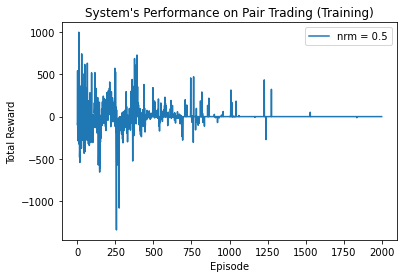

Start Testing.
#0000 Episode's Total Reward: 0000
#0001 Episode's Total Reward: 0000
#0002 Episode's Total Reward: 0000
#0003 Episode's Total Reward: 0000
#0004 Episode's Total Reward: 0000
#0005 Episode's Total Reward: 0000
#0006 Episode's Total Reward: 0000
#0007 Episode's Total Reward: 0000
#0008 Episode's Total Reward: 0000
#0009 Episode's Total Reward: 0000
#0010 Episode's Total Reward: 0000
#0011 Episode's Total Reward: 0000
#0012 Episode's Total Reward: 0000
#0013 Episode's Total Reward: 0000
#0014 Episode's Total Reward: 0000
#0015 Episode's Total Reward: 0000
#0016 Episode's Total Reward: 0000
#0017 Episode's Total Reward: 0000
#0018 Episode's Total Reward: 0000
#0019 Episode's Total Reward: 0000
#0020 Episode's Total Reward: 0000
#0021 Episode's Total Reward: 0000
#0022 Episode's Total Reward: 0000
#0023 Episode's Total Reward: 0000
#0024 Episode's Total Reward: 0000
#0025 Episode's Total Reward: 0000
#0026 Episode's Total Reward: 0000
#0027 Episode's Total Reward: 0000
#0028

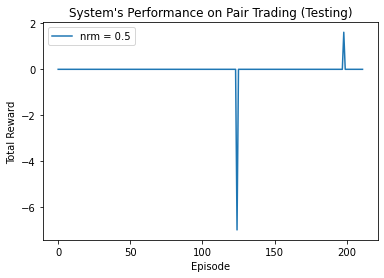

In [14]:
pair_trading_game = PairTradingGame()
 
pair_trading_game.start_training()
pair_trading_game.show_training_result()

pair_trading_game.start_testing()
pair_trading_game.show_testing_result()